# Prototype the catmon lastseen app

Prototype key functions and approach for the catmon_lastseen_app.py.

The streamlit web app will shows when Boo or Simba were last seen.

The app will parse the @boosimba catmon tweets, which include the cat images from
catmon, and the replies from the catmon image classifier that categorises
the cat image as Boo, Simba or Unknown.

The associated images will be enhanced and displayed.

Prototype
- twitter auth secrets management
- twitter access
- read catmon tweets and the catmon image classifier (catmonic) tweet replies efficiently 
- parse tweet data to extract the image and the classification
- image download from twitter
- image enhancement e.g. to brighten and resize
- display of friendly 'last seen' data and associated images
- ...

## Set-up

In [68]:
#check conda environment
conda_output = !conda info 
conda_active_env = [s.split(':')[1].strip() for s in conda_output if 'active environment :' in s][0]
print(f"conda active env is: {conda_active_env}")
assert conda_active_env == 'catmon_lastseen', f"Expecting conda_active_env to be 'catmon_lastseen'"

conda active env is: catmon_lastseen


In [69]:
import math
import os
import datetime as dt

import matplotlib.pyplot as plt
import pytz
import requests
import tweepy
import streamlit as st

from collections import OrderedDict
from configparser import ConfigParser
from io import BytesIO
from PIL import Image, ImageEnhance, ImageStat

In [70]:
print(f"requests version: {requests.__version__}")
print(f"streamlit version: {st.__version__}")
print(f"tweepy version: {tweepy.__version__}")

requests version: 2.28.1
streamlit version: 1.11.1
tweepy version: 4.10.0


**Note: streamlit is only used for secrets management in this notebook**

In [71]:
# define twitter related constants
BOOSIMBA_TWITTER_CONFIG_FILE = 'catmon_lastseen.ini' 
BOOSIMBA_TWITTER_USER_ID = 3022268453
BOOSIMBA_TWITTER_ACC_NAME = 'boosimba'

In [72]:
print(f"boosimba titter config file is: {BOOSIMBA_TWITTER_CONFIG_FILE}")
print(f"boosimba twitter user id is: {BOOSIMBA_TWITTER_USER_ID}")
print(f"boosimba account name is: {BOOSIMBA_TWITTER_ACC_NAME}")

boosimba titter config file is: catmon_lastseen.ini
boosimba twitter user id is: 3022268453
boosimba account name is: boosimba


## Prepare twitter access

In [73]:
# check twitter_auth_info
st.secrets.twitter_auth_info.keys()

dict_keys(['consumer_key', 'consumer_secret', 'access_token', 'access_token_secret'])

In [74]:
auth = tweepy.OAuth1UserHandler(**st.secrets.twitter_auth_info)
api = tweepy.API(auth)

## Use twitter API

In [75]:
# test api, get the user object for boosimba...
user = api.get_user(screen_name=BOOSIMBA_TWITTER_ACC_NAME)

# show user id and location
user_id = user.id
user_location = user.location
print(f"user id is: {user_id}, user location is: {user_location}")
assert user_id == BOOSIMBA_TWITTER_USER_ID and user_location == 'UK', "Unexpected error reading twitter user location"

user id is: 3022268453, user location is: UK


In [76]:
# show screen name and followers count
print(f"{user.screen_name} has {user.followers_count} followers")

boosimba has 23 followers


In [77]:
# helper function to get tweets replies (tweet thread) for a given tweet id
# https://stackoverflow.com/questions/29928638/getting-tweet-replies-to-a-particular-tweet-from-a-particular-user
# note that this is very inneficient, requiring all tweets to be checked for replies
def get_tweet_replies(username, tweet_id):
    "Return list of replies to given tweet id."
    ITEM_LIMIT = 100
    replies = tweepy.Cursor(
        api.search_tweets, 
        q='to:{}'.format(username),
        since_id=tweet_id, 
        tweet_mode='extended'
    ).items(ITEM_LIMIT)

    tweet_replies = list()
    for reply in replies:
        if(reply._json['in_reply_to_status_id'] == tweet_id):
             tweet_replies.append(reply)
        
    return tweet_replies

In [78]:
# get recent boosimba tweets (including replies) and show media url
# note user_timeline returns 20 most recent tweets (including retweets)
# add tweet_mode='extended' to ensure full text returned
public_tweets = api.user_timeline(tweet_mode='extended') 
for idx, tweet in enumerate(public_tweets):
    print(f"{idx} - tweet text: {tweet.full_text} (id={tweet.id})")
    if 'media' in tweet.entities:
        print(f"\tmedia_url: {tweet.entities['media'][0]['media_url']}")
    if tweet.in_reply_to_status_id_str:
        print(f"\treply to: {tweet.in_reply_to_status_id_str}")

0 - tweet text: Hello Simba

[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2] (id=1555054356428357633)
	reply to: 1555054323154944008
1 - tweet text: auto-tweet from catmon: 2022-08-04_055331.jpg https://t.co/eFjVVUyxrI (id=1555054323154944008)
	media_url: http://pbs.twimg.com/media/FZSpqrwXgAAiHHy.jpg
2 - tweet text: Hello Boo

[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2] (id=1555042806124666881)
	reply to: 1555042773706964994
3 - tweet text: auto-tweet from catmon: 2022-08-04_050737.jpg https://t.co/nyfTlMw2D3 (id=1555042773706964994)
	media_url: http://pbs.twimg.com/media/FZSfKZvXoAAAwEs.jpg
4 - tweet text: Hello Boo

[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2] (id=1555015877610930176)
	reply to: 1555015844865908736
5 - tweet text: auto-tweet from catmon: 2022-08-04_032037.jpg https://t.co/3VhaamMT0a

In [79]:
# get recent boosimba tweets (exclude replies) and show media url
public_tweets = api.user_timeline(tweet_mode='extended', exclude_replies=True)
for idx, tweet in enumerate(public_tweets):
    print(f"{idx} - tweet text: {tweet.full_text} (id={tweet.id})")
    if 'media' in tweet.entities:
        print(f"\tmedia_url: {tweet.entities['media'][0]['media_url']}")

0 - tweet text: auto-tweet from catmon: 2022-08-04_055331.jpg https://t.co/eFjVVUyxrI (id=1555054323154944008)
	media_url: http://pbs.twimg.com/media/FZSpqrwXgAAiHHy.jpg
1 - tweet text: auto-tweet from catmon: 2022-08-04_050737.jpg https://t.co/nyfTlMw2D3 (id=1555042773706964994)
	media_url: http://pbs.twimg.com/media/FZSfKZvXoAAAwEs.jpg
2 - tweet text: auto-tweet from catmon: 2022-08-04_032037.jpg https://t.co/3VhaamMT0a (id=1555015844865908736)
	media_url: http://pbs.twimg.com/media/FZSGq8lWAAEe_fu.jpg
3 - tweet text: auto-tweet from catmon: 2022-08-04_030229.jpg https://t.co/RhVAa9lEUI (id=1555011282520227840)
	media_url: http://pbs.twimg.com/media/FZSChXiX0AA6GH_.jpg
4 - tweet text: auto-tweet from catmon: 2022-08-04_014029.jpg https://t.co/JSqCeLPnbJ (id=1554990648037621760)
	media_url: http://pbs.twimg.com/media/FZRvwRRWYAAqXFf.jpg
5 - tweet text: auto-tweet from catmon: 2022-08-03_233551.jpg https://t.co/9vAjTmgAg6 (id=1554959287230816256)
	media_url: http://pbs.twimg.com/media/

In [80]:
%%time
# get recent boosimba tweets (exclude replies in initial pass) and show media url
# also retrieve the replies
public_tweets = api.user_timeline(tweet_mode='extended', exclude_replies=True)
for idx, tweet in enumerate(public_tweets):
    print(f"{idx} - tweet text: {tweet.full_text} (id={tweet.id})")
    if 'media' in tweet.entities:
        print(f"\tmedia_url: {tweet.entities['media'][0]['media_url']}")
    
    tweet_replies = get_tweet_replies('boosimba', tweet.id)
    for tweet_reply in tweet_replies:
        print('start reply:', '-'*60)
        print(tweet_reply.full_text)
        print('end reply:', '-'*60, '\n')

0 - tweet text: auto-tweet from catmon: 2022-08-04_055331.jpg https://t.co/eFjVVUyxrI (id=1555054323154944008)
	media_url: http://pbs.twimg.com/media/FZSpqrwXgAAiHHy.jpg
start reply: ------------------------------------------------------------
Hello Simba

[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2]
end reply: ------------------------------------------------------------ 

1 - tweet text: auto-tweet from catmon: 2022-08-04_050737.jpg https://t.co/nyfTlMw2D3 (id=1555042773706964994)
	media_url: http://pbs.twimg.com/media/FZSfKZvXoAAAwEs.jpg
start reply: ------------------------------------------------------------
Hello Boo

[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2]
end reply: ------------------------------------------------------------ 

2 - tweet text: auto-tweet from catmon: 2022-08-04_032037.jpg https://t.co/3VhaamMT0a (id=1555015844865908736)
	media_url: h

**note that this is very efficient way of retrieving tweets and their tweet_replies**

A better approach will be to extract tweets (pareent tweets and replies) on timeline and
split into tweet and tweet_reply dicts.

In [82]:
# show most recent (mr) tweet
# note that a tweet here excludes replies
mr_tweet = public_tweets[0]

In [83]:
# show entities for most recent tweet
mr_tweet.entities

{'hashtags': [],
 'symbols': [],
 'user_mentions': [],
 'urls': [],
 'media': [{'id': 1555054322114854912,
   'id_str': '1555054322114854912',
   'indices': [46, 69],
   'media_url': 'http://pbs.twimg.com/media/FZSpqrwXgAAiHHy.jpg',
   'media_url_https': 'https://pbs.twimg.com/media/FZSpqrwXgAAiHHy.jpg',
   'url': 'https://t.co/eFjVVUyxrI',
   'display_url': 'pic.twitter.com/eFjVVUyxrI',
   'expanded_url': 'https://twitter.com/boosimba/status/1555054323154944008/photo/1',
   'type': 'photo',
   'sizes': {'small': {'w': 640, 'h': 480, 'resize': 'fit'},
    'medium': {'w': 640, 'h': 480, 'resize': 'fit'},
    'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
    'large': {'w': 640, 'h': 480, 'resize': 'fit'}}}]}

In [84]:
mr_tweet_media_url = tweet.entities['media'][0]['media_url']
mr_tweet_media_url

'http://pbs.twimg.com/media/FZMleCQWIAASZ8r.jpg'

In [85]:
# explore most recent tweet...
print(type(mr_tweet))
print()
print(mr_tweet.entities.keys())
print()
print(mr_tweet.entities['media'])

<class 'tweepy.models.Status'>

dict_keys(['hashtags', 'symbols', 'user_mentions', 'urls', 'media'])

[{'id': 1555054322114854912, 'id_str': '1555054322114854912', 'indices': [46, 69], 'media_url': 'http://pbs.twimg.com/media/FZSpqrwXgAAiHHy.jpg', 'media_url_https': 'https://pbs.twimg.com/media/FZSpqrwXgAAiHHy.jpg', 'url': 'https://t.co/eFjVVUyxrI', 'display_url': 'pic.twitter.com/eFjVVUyxrI', 'expanded_url': 'https://twitter.com/boosimba/status/1555054323154944008/photo/1', 'type': 'photo', 'sizes': {'small': {'w': 640, 'h': 480, 'resize': 'fit'}, 'medium': {'w': 640, 'h': 480, 'resize': 'fit'}, 'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'large': {'w': 640, 'h': 480, 'resize': 'fit'}}}]


In [86]:
# get url of image from most recent tweet
media_url = mr_tweet.entities['media'][0]['media_url']
media_url

'http://pbs.twimg.com/media/FZSpqrwXgAAiHHy.jpg'

In [87]:
# get list of reply tweets for most recent tweet
mr_tweet_replies = get_tweet_replies('boosimba', mr_tweet.id)

if not mr_tweet_replies:
    print("no replies to last tweet")
else:
    # capture first reply and show its text
    mr_tweet_replies_first = mr_tweet_replies[0]
    mr_tweet_replies_first.full_text

In [88]:
mr_tweet_replies_first.full_text

'Hello Simba\n\n[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2]'

In [89]:
if mr_tweet_replies:
    print(mr_tweet_replies_first)

Status(_api=<tweepy.api.API object at 0x0000013A97DC3520>, _json={'created_at': 'Thu Aug 04 04:53:44 +0000 2022', 'id': 1555054356428357633, 'id_str': '1555054356428357633', 'full_text': 'Hello Simba\n\n[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2]', 'truncated': False, 'display_text_range': [0, 120], 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []}, 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'}, 'source': '<a href="http://terrysmusings.blogspot.co.uk/2015/03/catmon.html" rel="nofollow">catflapmon</a>', 'in_reply_to_status_id': 1555054323154944008, 'in_reply_to_status_id_str': '1555054323154944008', 'in_reply_to_user_id': 3022268453, 'in_reply_to_user_id_str': '3022268453', 'in_reply_to_screen_name': 'boosimba', 'user': {'id': 3022268453, 'id_str': '3022268453', 'name': 'boosimba', 'screen_name': 'boosimba', 'location': 'UK', 'description': 'Two cool #cats who like to tweet. Boo

In [90]:
if mr_tweet_replies:
    try:
        # show extended entities if present 
        print(mr_tweet_replies_first.extended_entities)
    except AttributeError as e:
        print("tweet reply does not have extended entities")

tweet reply does not have extended entities


In [91]:
if mr_tweet_replies:
    # show text of parent tweet
    # note that this is also extended
    print(mr_tweet_replies_first.full_text)

Hello Simba

[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2]


### Show image from a tweet

In [92]:
def image_download(media_url):
    """Download image at given media_url."""
    response = requests.get(media_url)
    img = Image.open(BytesIO(response.content))
    
    return img

(640, 480)


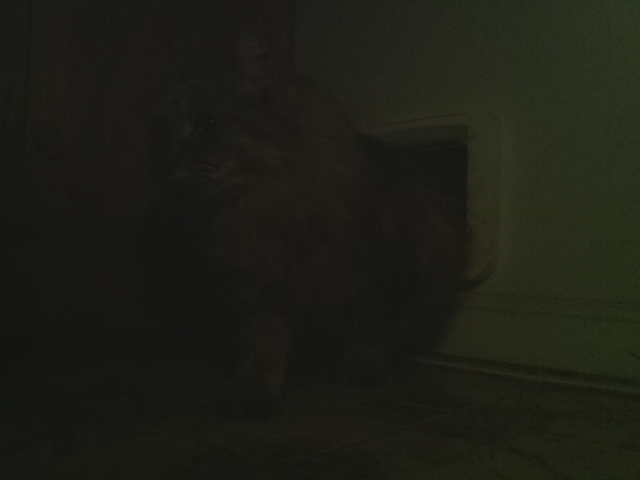

In [93]:
# show image from last tweet
img = image_download(mr_tweet_media_url)
print(img.size)
display(img)

## Define additional helper functions and check

In [94]:
def disp_before_and_after_images(image1, title1, image2, title2):
    fig, ax = plt.subplots(1,2, figsize=(15, 15))
    im1_brightness = get_image_brightness(image1)
    im2_brightness = get_image_brightness(image2)
    ax[0].imshow(image1)
    ax[0].set_title(f"{title1} ({im1_brightness:.2f})")
    ax[1].imshow(image2)
    ax[1].set_title(f"{title2} ({im2_brightness:.2f})")

In [95]:
def image_download(media_url):
    """Download image at given media_url."""
    response = requests.get(media_url)
    img = Image.open(BytesIO(response.content))

    return img

def is_catmon(tweet_full_text):
    """Return True if given tweet text is from catmon auto-tweet."""
    CATMON_START_TEXT = 'auto-tweet from catmon: '
    if tweet_full_text.startswith(CATMON_START_TEXT):
        return True

    return False

def is_catmonic(tweet_full_text):
    """Return True if given tweet text is from catmon image classification."""
    CATMONIC_TEXT = (
        'image automatically identified by the catmon image classifier cnn'
        )
    if CATMONIC_TEXT in tweet_full_text:
        return True

    return False

def get_catmonic_label(tweet_full_text):
    """Return label and reply text from the given tweet reply text.

    The classification label is provided by the catmon image classifier
    and can be 'boo' or 'simba'.
    """
    assert is_catmonic(tweet_full_text), (
        "unexpected error: tweet is not from catmon image classifier"
        )

    # get label from classification text
    if tweet_full_text.startswith('Hello Boo'):
        return 'boo'

    if tweet_full_text.startswith('Hello Simba'):
        return 'simba'

    raise ValueError('Unexpected error parsing catmon image classification, \
                     cannot find label')

def get_catmon_image(catmon_auto_tweet):
    """Return image filename and image url from catmon auto-tweet."""
    image_fname = catmon_auto_tweet.full_text.split(' ')[3]
    image_url = catmon_auto_tweet.entities['media'][0]['media_url']

    return image_fname, image_url

# ref: https://stackoverflow.com/questions/739241/date-ordinal-output
def ordinal(date_int):
    """Return string with date_int followed by ordinal suffix."""
    if 10 <= date_int % 100 < 20:
        return str(date_int) + 'th'

    return  str(date_int) + {1 : 'st', 2 : 'nd', 3 : 'rd'}.get(
        date_int % 10, "th"
        )

def get_friendly_lastseen_date(image_date_str):
    """Return a friendly date string.

    e.g. today at 17:30
    yesterday at 04:30
    Sunday 17th July at 05:00"""
    img_dt = dt.datetime.strptime(image_date_str, "%Y-%m-%d_%H%M%S")
    hours_ago = (dt.datetime.today() - img_dt).total_seconds()/(60*60)
    if img_dt.date() == dt.datetime.today().date():
        friendly_date_str = (
            f"today at {img_dt.time().strftime('%H:%M')} "
            f"- {hours_ago:.1f} hours ago"
            )
    elif img_dt.date() == (dt.datetime.today().date() - dt.timedelta(days=1)):
        friendly_date_str = (
            f"yesterday at {img_dt.time().strftime('%H:%M')} "
            f"- {hours_ago:.1f} hours ago"
            )
    else:
        dow = img_dt.date().strftime('%A')
        dom_digits = img_dt.date().strftime('%d')
        month = img_dt.date().strftime('%B')
        friendly_date_str = (
            f"{dow} {ordinal(int(dom_digits))} {month} at "
            f"{img_dt.time().strftime('%H:%M')} - {hours_ago:.1f} hours ago"
            )

    return friendly_date_str

def get_image_brightness(pil_image):
    """Calculate the perceived brightness of a given image object.

    Ref: https://stackoverflow.com/questions/3490727/what-are-some-methods-to-analyze-image-brightness-using-python
    Ref: http://alienryderflex.com/hsp.html

    The three constants (.299, .587, and .114) represent the different
    degrees to which each of the primary (RGB) colors affects human
    perception of the overall brightness of a color."""
    R_CONST = 0.299
    G_CONST = 0.587
    B_CONST = 0.114
    stat = ImageStat.Stat(pil_image)
    r, g, b = stat.mean

    return math.sqrt(R_CONST*(r**2) + G_CONST*(g**2) + B_CONST*(b**2))

# https://pythonexamples.org/python-pillow-adjust-image-brightness/
def enhance_image(pil_image, factor=1.8):
    """Return enhanced pil image.

    This is particularly useful for some of the darker, night-time images."""
    # instantiate the image brightness enhancer
    enhancer = ImageEnhance.Brightness(pil_image)

    # brighten the image
    img_output = enhancer.enhance(factor)

    return img_output

def parse_catmon_tweets(api, n=50):
    """Parse last n boosimba tweets (including replies) for catmon tweets.

       Return two dictionaries, one for tweets (containing the image name
       and link) and one for replies (with the full tweet text containing the
       image classification).
    """
    CATMON_USER_NAME = 'boosimba'

    # create ordered dicts
    # these are ordered to maintain date order, with most recent first
    tweet_reply_d = OrderedDict()
    tweet_d = OrderedDict()

    # get the public tweets from the catmon user's timeline
    # with tweet_mode='extended', to ensure full text returned
    public_tweets = api.user_timeline(tweet_mode='extended', count=n)

    # parse the public tweets and populate the two dictionaries
    for tweet in public_tweets:
        if tweet.user.screen_name != CATMON_USER_NAME:
            # ignore any tweets not from catmon user
            continue

        if tweet.in_reply_to_status_id_str:
            # this is a tweet reply
            if is_catmonic(tweet.full_text):
                # this is a catmon image classification
                tweet_reply_d[
                    int(tweet.in_reply_to_status_id_str)
                    ] = tweet.full_text
        elif is_catmon(tweet.full_text):
            # this is a catmon auto-tweet
            image_fname, image_url = get_catmon_image(tweet)
            tweet_d[tweet.id] = [image_fname, image_url]

    return tweet_d, tweet_reply_d

def get_last_seen(tweet_d, tweet_reply_d):
    """Return ordered dict with the 'last seen' most recent data

    Input: tweet and tweet reply ordered dicts
    Output: ordered dict keyed on label, with a value containing a tuple for
    image name and image url.
    """
    last_seen_d = OrderedDict()
    found_boo = found_simba = False

    for tweet_id, (image_fname, image_url) in tweet_d.items():
        if tweet_id in tweet_reply_d:
            label = get_catmonic_label(tweet_reply_d[tweet_id])

            if label == 'boo':
                found_boo = True
            if label == 'simba':
                found_simba = True
        else:
            label = 'unknown'

        if label not in last_seen_d:
            last_seen_d[label] = (image_fname, image_url)

        if found_boo and found_simba:
            break

    return last_seen_d

def resize(img, max_width=300):
    """Resize given PIL image to given max width, maintaining the aspect ratio.

    Note that most catmon images have size 600 x 400 (w x h), so a default
    resize will reduce the image size."""
    width, height = img.size
    ratio = max_width/width
    new_img = img.resize((int(width*ratio), int(height*ratio)))
    return new_img


In [96]:
# run parser and show the dictionaries
tweet_d, tweet_reply_d = parse_catmon_tweets(api, 10)
print(len(tweet_d), len(tweet_reply_d))
for k, v in tweet_d.items():
    print(k, v[0])
print()
print(tweet_d)
print()
print(tweet_reply_d)

5 5
1555054323154944008 2022-08-04_055331.jpg
1555042773706964994 2022-08-04_050737.jpg
1555015844865908736 2022-08-04_032037.jpg
1555011282520227840 2022-08-04_030229.jpg
1554990648037621760 2022-08-04_014029.jpg

OrderedDict([(1555054323154944008, ['2022-08-04_055331.jpg', 'http://pbs.twimg.com/media/FZSpqrwXgAAiHHy.jpg']), (1555042773706964994, ['2022-08-04_050737.jpg', 'http://pbs.twimg.com/media/FZSfKZvXoAAAwEs.jpg']), (1555015844865908736, ['2022-08-04_032037.jpg', 'http://pbs.twimg.com/media/FZSGq8lWAAEe_fu.jpg']), (1555011282520227840, ['2022-08-04_030229.jpg', 'http://pbs.twimg.com/media/FZSChXiX0AA6GH_.jpg']), (1554990648037621760, ['2022-08-04_014029.jpg', 'http://pbs.twimg.com/media/FZRvwRRWYAAqXFf.jpg'])])

OrderedDict([(1555054323154944008, 'Hello Simba\n\n[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2]'), (1555042773706964994, 'Hello Boo\n\n[probability: 100.0%, image automatically identified by the catmon image

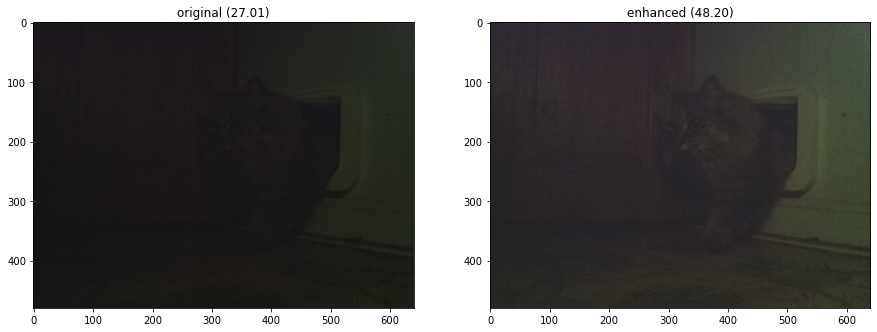

In [98]:
boo_dark_pil_image = Image.open('images/dark_boo.jpg')
boo_enh_pil_image = enhance_image(boo_dark_pil_image)
disp_before_and_after_images(boo_dark_pil_image, 'original', boo_enh_pil_image, 'enhanced')

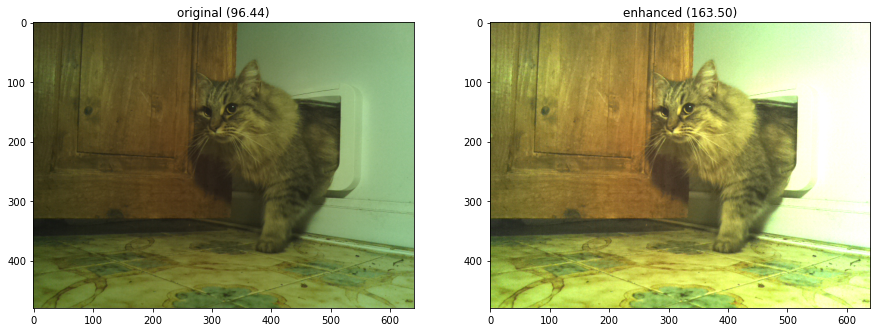

In [99]:
boo_normal_pil_image = Image.open('images/normal_boo.jpg')
boo_enh_pil_image = enhance_image(boo_normal_pil_image)
disp_before_and_after_images(boo_normal_pil_image, 'original', boo_enh_pil_image, 'enhanced')

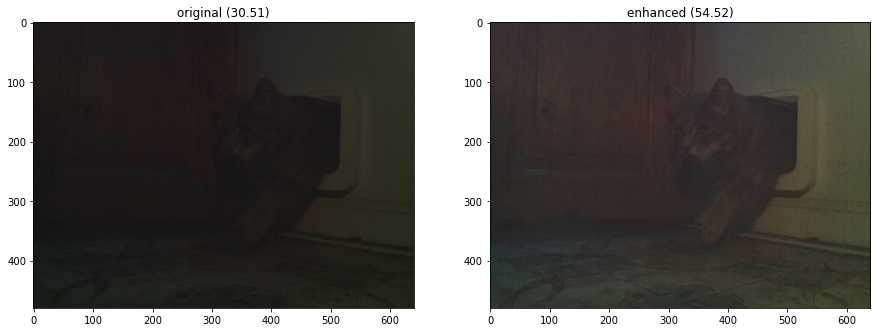

In [100]:
simba_dark_pil_image = Image.open('images/dark_simba.jpg')
simba_enh_pil_image = enhance_image(simba_dark_pil_image)
disp_before_and_after_images(simba_dark_pil_image, 'original', simba_enh_pil_image, 'enhanced')

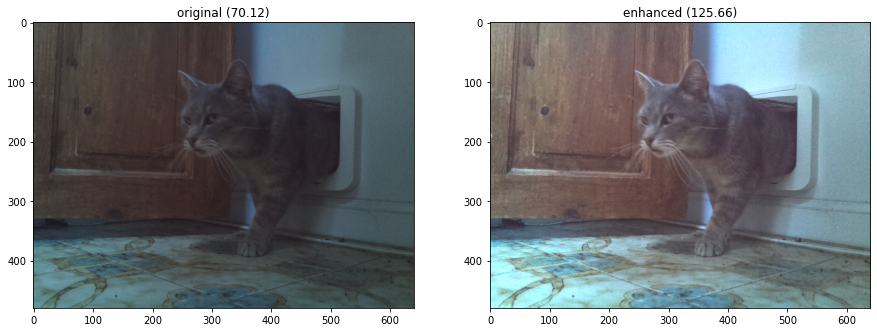

In [101]:
simba_normal_pil_image = Image.open('images/normal_simba.jpg')
simba_enh_pil_image = enhance_image(simba_normal_pil_image)
disp_before_and_after_images(simba_normal_pil_image, 'original', simba_enh_pil_image, 'enhanced')

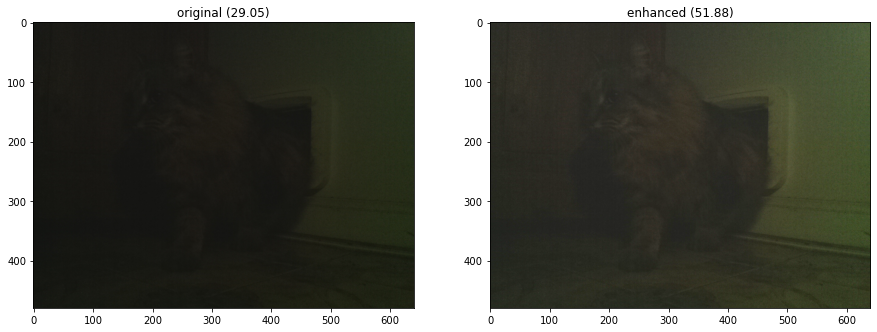

In [102]:
# test
mr_img = image_download(mr_tweet_media_url)
mr_enh_img = enhance_image(mr_img, factor=1.8)
disp_before_and_after_images(mr_img, 'original', mr_enh_img, 'enhanced')

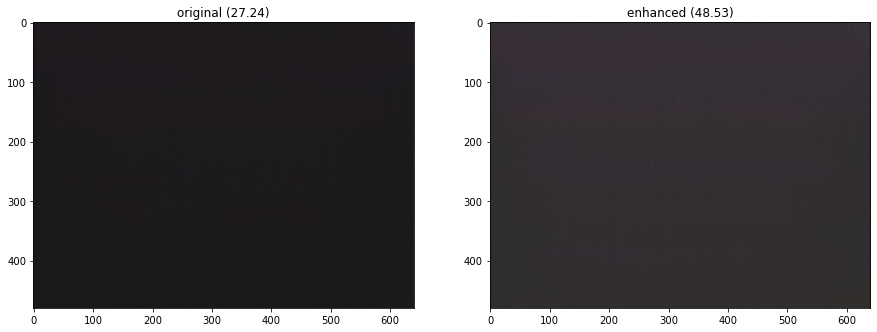

In [103]:
# test
unk_img = Image.open('images/dark_unknown.jpg')
unk_enh_img = enhance_image(unk_img)
disp_before_and_after_images(unk_img, 'original', unk_enh_img, 'enhanced')

In [104]:
# test
# assert is_catmon_autotweet(mr_tweet) == True, \
#     "Unexpected error, this should be an auto-tweet"
if mr_tweet_replies:
    assert is_catmon(mr_tweet_replies_first.full_text) == False, \
        "Unexpected error, this should not be an auto-tweet, it's a reply"

In [105]:
# test
text = """Hello Simba

[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2]"""
assert get_catmonic_label(text) == "simba"

text = """Hello Boo

[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2]"""
assert get_catmonic_label(text) == "boo"

text = """Hello Bob

[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2]"""
try:
    assert get_catmonic_label(text) == "simba"
    raise AttributeError("unexpected error, not expecting label to be simba!")
except ValueError:
    pass

In [106]:
print(f"most recent tweet has {len(mr_tweet_replies)} reply")
tweet_replies = mr_tweet_replies
for tweet_reply in tweet_replies:
    print(tweet_reply.full_text)
    if not is_catmonic(tweet_reply.full_text):
        # not a catmonic classification, so ignore
        print('not a catmonic reply')
        continue

    # get label from classification
    print(f"\nlabel is {get_catmonic_label(tweet_reply.full_text)}")

most recent tweet has 1 reply
Hello Simba

[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2]

label is simba


In [107]:
# test
get_catmonic_label(tweet_reply.full_text)

'simba'

In [108]:
# test
get_catmon_image(mr_tweet)

('2022-08-04_055331.jpg', 'http://pbs.twimg.com/media/FZSpqrwXgAAiHHy.jpg')

In [109]:
# test 
img_fname, img_url = get_catmon_image(mr_tweet)
img_fname, img_url

('2022-08-04_055331.jpg', 'http://pbs.twimg.com/media/FZSpqrwXgAAiHHy.jpg')

In [110]:
img_date_str = img_fname.split('.')[0]
img_date_str

'2022-08-04_055331'

In [111]:
# test
get_friendly_lastseen_date(img_date_str)

'today at 05:53 - 11.6 hours ago'

In [112]:
# test
today_dt = dt.datetime.today()
today_dt = today_dt.strftime("%Y-%m-%d_%H%M%S")
print(today_dt)
get_friendly_lastseen_date(today_dt)

2022-08-04_172723


'today at 17:27 - 0.0 hours ago'

In [113]:
# test
yesterday_dt = dt.datetime.today() - dt.timedelta(days=1)
yesterday_dt_str = yesterday_dt.strftime("%Y-%m-%d_%H%M%S")
print(yesterday_dt_str)
get_friendly_lastseen_date(yesterday_dt_str)

2022-08-03_172723


'yesterday at 17:27 - 24.0 hours ago'

In [114]:
# test
other_dt = dt.datetime.today() - dt.timedelta(days=20)
other_dt = other_dt.strftime("%Y-%m-%d_%H%M%S")
print(other_dt)
get_friendly_lastseen_date(other_dt)

2022-07-15_172723


'Friday 15th July at 17:27 - 480.0 hours ago'

----

## Show last seen data with images

In [115]:
tweet_d, tweet_reply_d = parse_catmon_tweets(api, 10)
if (set(tweet_d.keys()) != set(tweet_reply_d.keys())):
    print("dictionary keys are not the same, suggesting an 'unknown' classification(s)")
    
for tweet_id, (image_name, image_url) in tweet_d.items():
    print(tweet_id, image_name, image_url)
    if tweet_id in tweet_reply_d:
        print(f"\tlabel is: {get_catmonic_label(tweet_reply_d[tweet_id])}")

1555054323154944008 2022-08-04_055331.jpg http://pbs.twimg.com/media/FZSpqrwXgAAiHHy.jpg
	label is: simba
1555042773706964994 2022-08-04_050737.jpg http://pbs.twimg.com/media/FZSfKZvXoAAAwEs.jpg
	label is: boo
1555015844865908736 2022-08-04_032037.jpg http://pbs.twimg.com/media/FZSGq8lWAAEe_fu.jpg
	label is: boo
1555011282520227840 2022-08-04_030229.jpg http://pbs.twimg.com/media/FZSChXiX0AA6GH_.jpg
	label is: simba
1554990648037621760 2022-08-04_014029.jpg http://pbs.twimg.com/media/FZRvwRRWYAAqXFf.jpg
	label is: boo


In [116]:
def get_last_seen(tweet_d, tweet_reply_d):
    """Return ordered dict with 'last seen' data
    
    Input: tweet and tweet reply ordered dicts
    Output: ordered dict with classification label, 
    image name and image url
    """

    last_seen_d = OrderedDict()
    found_boo = found_simba = False
    
    for tweet_id, (image_name, image_url) in tweet_d.items():
#         print(tweet_id, image_name, image_url)
        if tweet_id in tweet_reply_d:
            label = get_catmonic_label(tweet_reply_d[tweet_id])
#             print(f"\tlabel is: {label}")

            if label == 'boo': 
                found_boo = True
            if label == 'simba': 
                found_simba = True
        else:
            label = 'unknown'
#             print(f"\tinferred label is: {label}")

        if label not in last_seen_d:
            last_seen_d[label] = (image_name, image_url)

        if found_boo and found_simba:
            break
    
    return last_seen_d

parse catmon tweet...
get last seen data...
show last seen info:

Simba was last seen today at 05:53 - 11.6 hours ago
Boo was last seen today at 05:07 - 12.3 hours ago


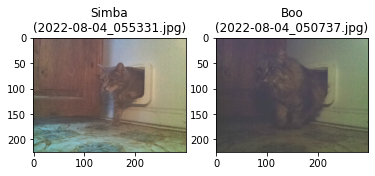

CPU times: total: 344 ms
Wall time: 766 ms


In [117]:
%%time
USER_TWEET_COUNT = 50 # max is 200
# create tweet dictionaries
print("parse catmon tweet...")
tweet_d, tweet_reply_d = parse_catmon_tweets(api, USER_TWEET_COUNT)
# print(tweet_d)
# print(tweet_reply_d)

print("get last seen data...")
last_seen_d = get_last_seen(tweet_d, tweet_reply_d)
# print(last_seen_d)

print("show last seen info:\n")
found_boo = True if 'boo' in last_seen_d else False
found_simba = True if 'simba' in last_seen_d else False
found_unknown = True if 'unknown' in last_seen_d else False
# print(f"found_boo: {found_boo}, found_simba: {found_simba}, found_unknown: {found_unknown}\n")
images = []
if last_seen_d:  
    for label, (image_name, image_url) in last_seen_d.items():
        img_date_str = image_name.split('.')[0]
        friendly_lastseen_date = get_friendly_lastseen_date(img_date_str)
        print(f"{label.capitalize()} was last seen {friendly_lastseen_date}")
        
        img = image_download(image_url)
        img_enh = enhance_image(img, factor=1.8)
        images.append((label, image_name, img_enh))

#     print(images) # image size: (640, 480)
    
    fig, ax = plt.subplots(1, len(images), squeeze=False)
    ax = ax.flatten()
    for idx, (image_label, image_name, image_pil) in enumerate(images):
#         print(idx, image_label, image_name, image_pil)
        ax[idx].imshow(resize(enhance_image(image_pil, factor=1.8)))
        ax[idx].set_title(f"{image_label.capitalize()}\n({image_name})")           
    plt.show()
        
if not found_simba and not found_boo:
    print(f'Could not find Boo or Simba in last {len(tweet_d)} tweets from @boosimba')
else:
    if not found_boo:        
        print(f'Could not find Boo in last {len(tweet_d)} tweets from @boosimba')
    if not found_simba:        
        print(f'Could not find Simba in last {len(tweet_d)} tweets from @boosimba')

In [118]:
images

[('simba',
  '2022-08-04_055331.jpg',
  <PIL.Image.Image image mode=RGB size=640x480 at 0x13A951B6E20>),
 ('boo',
  '2022-08-04_050737.jpg',
  <PIL.Image.Image image mode=RGB size=640x480 at 0x13A97A68C10>)]

In [119]:
labels, image_fnames, image_PILs = list(zip(*images))
captions = [f"{label}\n({image_fname})" for label in labels for image_fname in image_fnames]
captions

['simba\n(2022-08-04_055331.jpg)',
 'simba\n(2022-08-04_050737.jpg)',
 'boo\n(2022-08-04_055331.jpg)',
 'boo\n(2022-08-04_050737.jpg)']

In [51]:
labels, image_fnames, image_PILs

(('simba', 'boo'),
 ('2022-08-04_055331.jpg', '2022-08-04_050737.jpg'),
 (<PIL.Image.Image image mode=RGB size=640x480 at 0x13A9799F0A0>,
  <PIL.Image.Image image mode=RGB size=640x480 at 0x13A950309A0>))

---

## Edge case testing

OrderedDict([('unknown', ('2022-08-04_055331.jpg', 'http://pbs.twimg.com/media/FZSpqrwXgAAiHHy.jpg'))])
show last seen info:

Unknown was last seen today at 05:53 - 10.2 hours ago


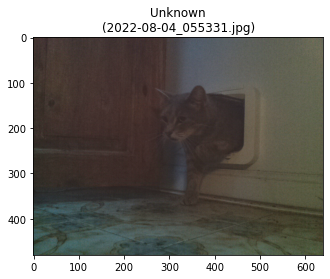

Could not find Boo or Simba in last 25 tweets from @boosimba


In [52]:
# test with empty tweet_reply_d, expect 1 unknown entry
last_seen_d = get_last_seen(tweet_d, {})
print(last_seen_d)

print("show last seen info:\n")
found_boo = True if 'boo' in last_seen_d else False
found_simba = True if 'simba' in last_seen_d else False
found_unknown = True if 'unknown' in last_seen_d else False
# print(f"found_boo: {found_boo}, found_simba: {found_simba}, found_unknown: {found_unknown}\n")
images = []
if last_seen_d:  
    for label, (image_name, image_url) in last_seen_d.items():
        img_date_str = image_name.split('.')[0]
        friendly_lastseen_date = get_friendly_lastseen_date(img_date_str)
        print(f"{label.capitalize()} was last seen {friendly_lastseen_date}")
        
        img = image_download(image_url)
        img_enh = enhance_image(img, factor=1.8)
        images.append((label, image_name, img_enh))

#     print(images) # image size: (640, 480)
    
    fig, ax = plt.subplots(1, len(images), squeeze=False)
    ax = ax.flatten()
    for idx, (image_label, image_name, image_pil) in enumerate(images):
#         print(idx, image_label, image_name, image_pil)
        ax[idx].imshow(image_pil)
        ax[idx].set_title(f"{image_label.capitalize()}\n({image_name})")           
    plt.show()
        
if not found_simba and not found_boo:
    print(f'Could not find Boo or Simba in last {len(tweet_d)} tweets from @boosimba')
else:
    if not found_boo:        
        print(f'Could not find Boo in last {len(tweet_d)} tweets from @boosimba')
    if not found_simba:        
        print(f'Could not find Simba in last {len(tweet_d)} tweets from @boosimba')

In [53]:
# generate dummy unknown entry and add to beginning of ordered dict
unk = {123: ['2022-07-08_004224.jpg', 'http://pbs.twimg.com/media/FXGfh8NX0AAYaj3.jpg']}
tweet_d.update(unk)

tweet_d.move_to_end(123, last=False)
tweet_d

OrderedDict([(123,
              ['2022-07-08_004224.jpg',
               'http://pbs.twimg.com/media/FXGfh8NX0AAYaj3.jpg']),
             (1555054323154944008,
              ['2022-08-04_055331.jpg',
               'http://pbs.twimg.com/media/FZSpqrwXgAAiHHy.jpg']),
             (1555042773706964994,
              ['2022-08-04_050737.jpg',
               'http://pbs.twimg.com/media/FZSfKZvXoAAAwEs.jpg']),
             (1555015844865908736,
              ['2022-08-04_032037.jpg',
               'http://pbs.twimg.com/media/FZSGq8lWAAEe_fu.jpg']),
             (1555011282520227840,
              ['2022-08-04_030229.jpg',
               'http://pbs.twimg.com/media/FZSChXiX0AA6GH_.jpg']),
             (1554990648037621760,
              ['2022-08-04_014029.jpg',
               'http://pbs.twimg.com/media/FZRvwRRWYAAqXFf.jpg']),
             (1554959287230816256,
              ['2022-08-03_233551.jpg',
               'http://pbs.twimg.com/media/FZRTO3gWAAUmwdl.jpg']),
             (15546767

get last seen data...
OrderedDict([('unknown', ('2022-07-08_004224.jpg', 'http://pbs.twimg.com/media/FXGfh8NX0AAYaj3.jpg')), ('simba', ('2022-08-04_055331.jpg', 'http://pbs.twimg.com/media/FZSpqrwXgAAiHHy.jpg')), ('boo', ('2022-08-04_050737.jpg', 'http://pbs.twimg.com/media/FZSfKZvXoAAAwEs.jpg'))])
show last seen info:

Unknown was last seen Friday 8th July at 00:42 - 663.4 hours ago
Simba was last seen today at 05:53 - 10.2 hours ago
Boo was last seen today at 05:07 - 11.0 hours ago


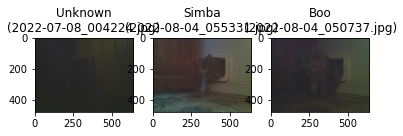

In [54]:
# test with amended tweet_d, expect 1 unknown entry at beginning
print("get last seen data...")
last_seen_d = get_last_seen(tweet_d, tweet_reply_d)
print(last_seen_d)

print("show last seen info:\n")
found_boo = True if 'boo' in last_seen_d else False
found_simba = True if 'simba' in last_seen_d else False
found_unknown = True if 'unknown' in last_seen_d else False
# print(f"found_boo: {found_boo}, found_simba: {found_simba}, found_unknown: {found_unknown}\n")
images = []
if last_seen_d:  
    for label, (image_name, image_url) in last_seen_d.items():
        img_date_str = image_name.split('.')[0]
        friendly_lastseen_date = get_friendly_lastseen_date(img_date_str)
        print(f"{label.capitalize()} was last seen {friendly_lastseen_date}")
        
        img = image_download(image_url)
        img_enh = enhance_image(img, factor=1.8)
        images.append((label, image_name, img_enh))

#     print(images) # image size: (640, 480)
    
    fig, ax = plt.subplots(1, len(images), squeeze=False)
    ax = ax.flatten()
    for idx, (image_label, image_name, image_pil) in enumerate(images):
#         print(idx, image_label, image_name, image_pil)
        ax[idx].imshow(image_pil)
        ax[idx].set_title(f"{image_label.capitalize()}\n({image_name})")           
    plt.show()
        
if not found_simba and not found_boo:
    print(f'Could not find Boo or Simba in last {len(tweet_d)} tweets from @boosimba')
else:
    if not found_boo:        
        print(f'Could not find Boo in last {len(tweet_d)} tweets from @boosimba')
    if not found_simba:        
        print(f'Could not find Simba in last {len(tweet_d)} tweets from @boosimba')

In [55]:
# test, remove boo from tweet_reply_d
tweet_d, tweet_reply_d = parse_catmon_tweets(api, 10)
print(tweet_reply_d)
remove_ids = []
for tweet_id, classification_str in tweet_reply_d.items():
    if 'Hello Boo' in classification_str:
        print(tweet_id, classification_str)
        remove_ids.append(tweet_id)
print(remove_ids)
for tweet_id in remove_ids:
    tweet_reply_d.pop(tweet_id, None)
print(tweet_reply_d)

OrderedDict([(1555054323154944008, 'Hello Simba\n\n[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2]'), (1555042773706964994, 'Hello Boo\n\n[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2]'), (1555015844865908736, 'Hello Boo\n\n[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2]'), (1555011282520227840, 'Hello Simba\n\n[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2]'), (1554990648037621760, 'Hello Boo\n\n[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2]')])
1555042773706964994 Hello Boo

[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2]
1555015844865908736 Hello Boo

[probability: 100.0%, image automatically identified by the catmon image clas

get last seen data...
OrderedDict([('simba', ('2022-08-04_055331.jpg', 'http://pbs.twimg.com/media/FZSpqrwXgAAiHHy.jpg')), ('unknown', ('2022-08-04_050737.jpg', 'http://pbs.twimg.com/media/FZSfKZvXoAAAwEs.jpg'))])
show last seen info:

Simba was last seen today at 05:53 - 10.2 hours ago
Unknown was last seen today at 05:07 - 11.0 hours ago


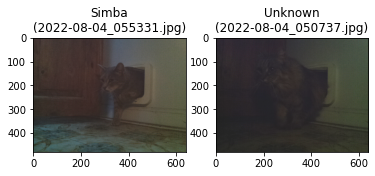

Could not find Boo in last 5 tweets from @boosimba


In [56]:
# test with amended tweet_reply_d, expect no boo entries (replaced by unknown)
print("get last seen data...")
last_seen_d = get_last_seen(tweet_d, tweet_reply_d)
print(last_seen_d)

print("show last seen info:\n")
found_boo = True if 'boo' in last_seen_d else False
found_simba = True if 'simba' in last_seen_d else False
found_unknown = True if 'unknown' in last_seen_d else False
# print(f"found_boo: {found_boo}, found_simba: {found_simba}, found_unknown: {found_unknown}\n")
images = []
if last_seen_d:  
    for label, (image_name, image_url) in last_seen_d.items():
        img_date_str = image_name.split('.')[0]
        friendly_lastseen_date = get_friendly_lastseen_date(img_date_str)
        print(f"{label.capitalize()} was last seen {friendly_lastseen_date}")
        
        img = image_download(image_url)
        img_enh = enhance_image(img, factor=1.8)
        images.append((label, image_name, img_enh))

#     print(images) # image size: (640, 480)
    
    fig, ax = plt.subplots(1, len(images), squeeze=False)
    ax = ax.flatten()
    for idx, (image_label, image_name, image_pil) in enumerate(images):
#         print(idx, image_label, image_name, image_pil)
        ax[idx].imshow(image_pil)
        ax[idx].set_title(f"{image_label.capitalize()}\n({image_name})")           
    plt.show()
        
if not found_simba and not found_boo:
    print(f'Could not find Boo or Simba in last {len(tweet_d)} tweets from @boosimba')
else:
    if not found_boo:        
        print(f'Could not find Boo in last {len(tweet_d)} tweets from @boosimba')
    if not found_simba:        
        print(f'Could not find Simba in last {len(tweet_d)} tweets from @boosimba')

In [57]:
# test, remove simba from tweet_reply_d
tweet_d, tweet_reply_d = parse_catmon_tweets(api, 10)
print(tweet_reply_d)
remove_ids = []
for tweet_id, classification_str in tweet_reply_d.items():
    if 'Hello Simba' in classification_str:
        print(tweet_id, classification_str)
        remove_ids.append(tweet_id)
print(remove_ids)
for tweet_id in remove_ids:
    tweet_reply_d.pop(tweet_id, None)
print(tweet_reply_d)

OrderedDict([(1555054323154944008, 'Hello Simba\n\n[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2]'), (1555042773706964994, 'Hello Boo\n\n[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2]'), (1555015844865908736, 'Hello Boo\n\n[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2]'), (1555011282520227840, 'Hello Simba\n\n[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2]'), (1554990648037621760, 'Hello Boo\n\n[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2]')])
1555054323154944008 Hello Simba

[probability: 100.0%, image automatically identified by the catmon image classifier cnn, using MobileNetV2]
1555011282520227840 Hello Simba

[probability: 100.0%, image automatically identified by the catmon image 

get last seen data...
OrderedDict([('unknown', ('2022-08-04_055331.jpg', 'http://pbs.twimg.com/media/FZSpqrwXgAAiHHy.jpg')), ('boo', ('2022-08-04_050737.jpg', 'http://pbs.twimg.com/media/FZSfKZvXoAAAwEs.jpg'))])
show last seen info:

Unknown was last seen today at 05:53 - 10.2 hours ago
Boo was last seen today at 05:07 - 11.0 hours ago


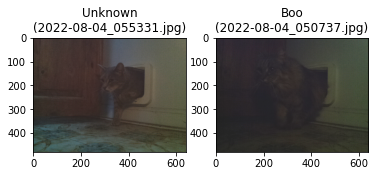

Could not find Simba in last 5 tweets from @boosimba


In [58]:
# test with amended tweet_reply_d, expect no simba entries (replaced by unknown)
print("get last seen data...")
last_seen_d = get_last_seen(tweet_d, tweet_reply_d)
print(last_seen_d)

print("show last seen info:\n")
found_boo = True if 'boo' in last_seen_d else False
found_simba = True if 'simba' in last_seen_d else False
found_unknown = True if 'unknown' in last_seen_d else False
# print(f"found_boo: {found_boo}, found_simba: {found_simba}, found_unknown: {found_unknown}\n")
images = []
if last_seen_d:  
    for label, (image_name, image_url) in last_seen_d.items():
        img_date_str = image_name.split('.')[0]
        friendly_lastseen_date = get_friendly_lastseen_date(img_date_str)
        print(f"{label.capitalize()} was last seen {friendly_lastseen_date}")
        
        img = image_download(image_url)
        img_enh = enhance_image(img, factor=1.8)
        images.append((label, image_name, img_enh))

#     print(images) # image size: (640, 480)
    
    fig, ax = plt.subplots(1, len(images), squeeze=False)
    ax = ax.flatten()
    for idx, (image_label, image_name, image_pil) in enumerate(images):
#         print(idx, image_label, image_name, image_pil)
        ax[idx].imshow(image_pil)
        ax[idx].set_title(f"{image_label.capitalize()}\n({image_name})")           
    plt.show()
        
if not found_simba and not found_boo:
    print(f'Could not find Boo or Simba in last {len(tweet_d)} tweets from @boosimba')
else:
    if not found_boo:        
        print(f'Could not find Boo in last {len(tweet_d)} tweets from @boosimba')
    if not found_simba:        
        print(f'Could not find Simba in last {len(tweet_d)} tweets from @boosimba')

In [59]:
# test with amended tweet_reply_d, expect no simba entries (replaced by unknown)
print("get last seen data...")
last_seen_d = get_last_seen({}, {})
print(last_seen_d)

print("show last seen info:\n")
found_boo = True if 'boo' in last_seen_d else False
found_simba = True if 'simba' in last_seen_d else False
found_unknown = True if 'unknown' in last_seen_d else False
# print(f"found_boo: {found_boo}, found_simba: {found_simba}, found_unknown: {found_unknown}\n")
images = []
if last_seen_d:  
    for label, (image_name, image_url) in last_seen_d.items():
        img_date_str = image_name.split('.')[0]
        friendly_lastseen_date = get_friendly_lastseen_date(img_date_str)
        print(f"{label.capitalize()} was last seen {friendly_lastseen_date}")
        
        img = image_download(image_url)
        img_enh = enhance_image(img, factor=1.8)
        images.append((label, image_name, img_enh))

#     print(images) # image size: (640, 480)
    
    fig, ax = plt.subplots(1, len(images), squeeze=False, figsize=(10, 8))
    ax = ax.flatten()
    for idx, (image_label, image_name, image_pil) in enumerate(images):
#         print(idx, image_label, image_name, image_pil)
        ax[idx].imshow(image_pil)
        ax[idx].set_title(f"{image_label.capitalize()} ({image_name})")           
    plt.show()
        
if not found_simba and not found_boo:
    print(f'Could not find Boo or Simba in last {len(tweet_d)} tweets from @boosimba')
else:
    if not found_boo:        
        print(f'Could not find Boo in last {len(tweet_d)} tweets from @boosimba')
    if not found_simba:        
        print(f'Could not find Simba in last {len(tweet_d)} tweets from @boosimba')

get last seen data...
OrderedDict()
show last seen info:

Could not find Boo or Simba in last 5 tweets from @boosimba
